# 🧪 Atividade Didática — Feature Engineering com Random Forest (Dataset Wine - scikit-learn)

**Objetivo:** Demonstrar, passo a passo, como **derivar novas features** e avaliar seu impacto no desempenho
de um **RandomForestClassifier** usando validação cruzada e análise de importância de variáveis.

**Por que Wine?** É um dataset multiclasse (3 classes de vinho) com variáveis físico‑químicas contínuas,
bom para praticar hipóteses e criação de atributos compostos.

> Estrutura:
> 1) Carregar e explorar dados  
> 2) Baseline (modelo com features originais)  
> 3) Criar **2 features guiadas** (obrigatórias)  
> 4) Comparar desempenho (CV) e analisar importâncias  
> 5) **Tarefa**: criar **+3 features autorais** e reavaliar


In [ ]:
# === Imports básicos ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# Estética simples para plots (sem estilos específicos)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


## 1) Carregar e explorar dados

Usaremos o **dataset Wine** do `scikit-learn`. As colunas são medidas químicas; a variável‑alvo é a classe do vinho (`target`).


In [ ]:
# Carregar dataset
wine = load_wine(as_frame=True)
df = wine.frame.copy()  # contém features + target
df.rename(columns={"target": "class"}, inplace=True)

print("Shape:", df.shape)
df.head()


Shape: (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [ ]:
# Estatísticas descritivas rápidas
df.describe().T


,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


### Definição de variáveis

- **X_base**: conjunto de features **originais** (todas as colunas exceto `class`).  
- **y**: vetor de rótulos (0, 1, 2).


In [ ]:
# Separar X e y (baseline com features originais)
feature_cols = [c for c in df.columns if c != "class"]
X_base = df[feature_cols].copy()
y = df["class"].values

print("N features (originais):", X_base.shape[1])


N features (originais): 13


## 2) Baseline: Random Forest com features originais

Usaremos validação cruzada estratificada (5 folds) e métrica **acurácia** como referência didática.


In [ ]:
# Configuração de CV e modelo
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

scores_base = cross_val_score(rf, X_base, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia (CV=5) - Baseline: {scores_base.mean():.4f} ± {scores_base.std():.4f}")


Acurácia (CV=5) - Baseline: 0.9830 ± 0.0228


In [ ]:
# Ajustar em todos os dados para visualizar importâncias (apenas para fins didáticos)
rf.fit(X_base, y)
importances_base = pd.Series(rf.feature_importances_, index=X_base.columns).sort_values(ascending=False)

ax = importances_base.head(15).sort_values().plot.barh()
ax.set_title("Importância das features (Baseline - top 15)")
ax.set_xlabel("Gini importance")
plt.show()


## 3) **Duas features guiadas (obrigatórias)**

As novas variáveis a seguir são **exemplos** de hipóteses químicas simplificadas. A ideia é combinar
medidas que **podem se relacionar** com propriedades sensoriais/estruturais do vinho.

> **Feature 1 — `phenolic_ratio`**  
> **Definição:** `total_phenols / (flavanoids + 1e-6)`  
> **Motivação:** Compostos fenólicos e flavonoides influenciam corpo, adstringência e estabilidade. A razão pode capturar
> **equilíbrio** dentro do perfil fenólico.

> **Feature 2 — `color_od_index`**  
> **Definição:** `color_intensity / (od280/od315_of_diluted_wines + 1e-6)`  
> **Motivação:** Relação entre intensidade de cor e medida espectrofotométrica OD280/OD315 pode indicar **densidade de cor por unidade de compostos detectados**, diferenciando classes.

> Obs.: O `+ 1e-6` evita divisão por zero.


In [ ]:
# Criar cópia de trabalho para engenharia de atributos
df_fe = df.copy()

# Feature 1
df_fe["phenolic_ratio"] = df_fe["total_phenols"] / (df_fe["flavanoids"] + 1e-6)

# Feature 2
df_fe["color_od_index"] = df_fe["color_intensity"] / (df_fe["od280/od315_of_diluted_wines"] + 1e-6)

# Novo conjunto de features (originais + 2 novas)
X_2feat = df_fe.drop(columns=["class"])

print("Total de features com as 2 guiadas:", X_2feat.shape[1])
df_fe[["total_phenols","flavanoids","phenolic_ratio",
       "color_intensity","od280/od315_of_diluted_wines","color_od_index"]].head()


### Avaliar impacto das 2 features guiadas

Comparamos a acurácia média em CV (5 folds) entre **Baseline** e **+2 features**.


In [ ]:
scores_2feat = cross_val_score(rf, X_2feat, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia (CV=5) - +2 features: {scores_2feat.mean():.4f} ± {scores_2feat.std():.4f}")

delta = scores_2feat.mean() - scores_base.mean()
print(f"Δ Acurácia (2 features - baseline): {delta:+.4f}")


In [ ]:
# Importâncias após adicionar as 2 features
rf.fit(X_2feat, y)
importances_2 = pd.Series(rf.feature_importances_, index=X_2feat.columns).sort_values(ascending=False)

ax = importances_2.head(15).sort_values().plot.barh()
ax.set_title("Importância das features (com 2 guiadas - top 15)")
ax.set_xlabel("Gini importance")
plt.show()


### Importância por Permutação (Permutation Importance)

Mais robusta para avaliar impacto individual na métrica de desempenho.


In [ ]:
rf.fit(X_2feat, y)
r_perm = permutation_importance(rf, X_2feat, y, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    "feature": X_2feat.columns,
    "importance_mean": r_perm.importances_mean,
    "importance_std": r_perm.importances_std
}).sort_values("importance_mean", ascending=False)

perm_df.head(15)


In [ ]:
# Plot rápido da importância por permutação (top 15)
top = perm_df.head(15).sort_values("importance_mean")
plt.barh(top["feature"], top["importance_mean"])
plt.xlabel("Permutation importance (mean Δ accuracy)")
plt.title("Permutation Importance - top 15 (2 features guiadas)")
plt.show()


## 4) **Tarefa do aluno/grupo** — Criar **+3 features autorais**

Crie pelo menos **três novas variáveis** com base em hipóteses químicas ou relações proporcionais entre medidas.
**Justifique cada uma** em um comentário (markdown) e **reavalie** o desempenho do modelo.

### Exemplos de inspiração (opcionais, não prescritivos)
- `ash_alcalinity_ratio = ash / (alcalinity_of_ash + 1e-6)`  
- `magnesium_scaled = magnesium / proline`  
- `phenolic_strength = (total_phenols + proanthocyanins) / (flavanoids + 1e-6)`  
- **Interações** (produto) e **proporções** (razões) frequentemente capturam relações úteis.

> **ATENÇÃO:** Evite criar atributos que sejam combinação linear trivial de outros já altamente correlacionados sem justificativa.


In [ ]:
# === TODO (aluno): criar +3 features aqui ===
df_student = df_fe.copy()

# EXEMPLO (substitua/edite com as suas ideias) ---------------------
# df_student["ash_alcalinity_ratio"] = df_student["ash"] / (df_student["alcalinity_of_ash"] + 1e-6)
# df_student["phenolic_strength"] = (df_student["total_phenols"] + df_student["proanthocyanins"]) / (df_student["flavanoids"] + 1e-6)
# df_student["intensity_proline_ratio"] = df_student["color_intensity"] / (df_student["proline"] + 1e-6)
# ------------------------------------------------------------------

X_student = df_student.drop(columns=["class"])
print("Features após +3 autorais (esperado > 2 guiadas):", X_student.shape[1])


### Reavaliar desempenho com as **+3 features autorais**

Compare com Baseline e com **+2 guiadas**.


In [ ]:
scores_student = cross_val_score(rf, X_student, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia (CV=5) - +3 autorais (além das 2 guiadas): {scores_student.mean():.4f} ± {scores_student.std():.4f}")

print("\nResumo:")
print(f"Baseline        : {scores_base.mean():.4f}")
print(f"+2 guiadas      : {scores_2feat.mean():.4f} (Δ {scores_2feat.mean() - scores_base.mean():+.4f})")
print(f"+3 autorais (+2): {scores_student.mean():.4f} (Δ {scores_student.mean() - scores_2feat.mean():+.4f})")


In [ ]:
# Importâncias com as +3 autorais (se criadas)
rf.fit(X_student, y)
importances_student = pd.Series(rf.feature_importances_, index=X_student.columns).sort_values(ascending=False)

ax = importances_student.head(20).sort_values().plot.barh()
ax.set_title("Importância das features (com +3 autorais - top 20)")
ax.set_xlabel("Gini importance")
plt.show()


## 5) Conclusão e reflexão

- Quais features novas mais contribuíram para a melhora de desempenho?  
- Alguma feature diminuiu a acurácia? Por quê?  
- O conjunto de variáveis ficou mais **interpretável**?  
- Se você fosse **implantar** este modelo, quais atributos **manteria** e por quê?

> **Extensão:** testar `class_weight="balanced_subsample"`, ajustar `n_estimators`, `max_depth`,
e comparar com outras famílias de modelos (p. ex., `GradientBoosting`, `LogisticRegression`) mantendo o mesmo protocolo de avaliação.


Acurácia Média (CV=5) - Baseline (Modelo A): 0.8339 ± 0.0324
Acurácia Média (CV=5) - Com 2 Features (Modelo B): 0.8215 ± 0.0184
-> Ganho de Acurácia (B - A): -0.0123
Acurácia Média (CV=5) - Com +3 Features (Modelo C): 0.8271 ± 0.0167
-> Ganho de Acurácia (C - B): +0.0056

--- Resumo dos Resultados ---
Modelo A (Baseline)        : 0.8339
Modelo B (+2 Features)     : 0.8215 (Ganho: -0.0123)
Modelo C (+5 Features Total): 0.8271 (Ganho: -0.0067)


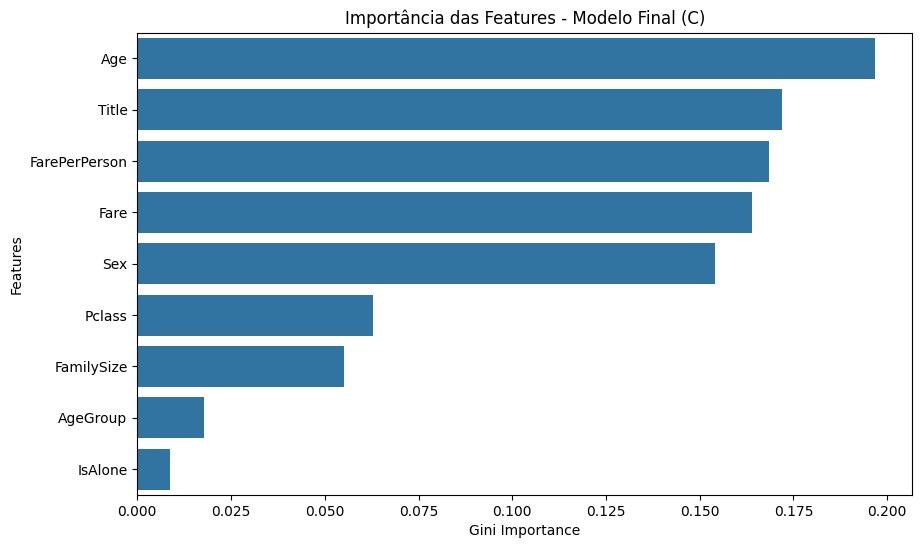

In [ ]:
#Atividade Titanic.csv

# === 1. Imports e Carregamento dos Dados ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from io import StringIO

# Dados de exemplo do 'train.csv' do Titanic
csv_data = """PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,,Q
"""
# Carregando os dados em um DataFrame
df = pd.read_csv('train.csv')

# === 2. Pré-processamento Básico ===

# Tratar valores ausentes (estratégias simples)
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Converter variáveis categóricas em numéricas
# Sexo (Sex): 'male' -> 0, 'female' -> 1
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)

# Separar features (X) e alvo (y)
y = df['Survived']
# Manter uma cópia do dataframe original para criar as features
df_features = df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']) # Removendo colunas não usadas inicialmente

# === 3. Modelo A: Baseline com Features Originais ===

# Definir as features do baseline
features_baseline = ['Pclass', 'Sex', 'Age', 'Fare']
X_base = df_features[features_baseline].copy()

# Configuração do modelo e da validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Avaliar o modelo baseline
scores_base = cross_val_score(rf, X_base, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia Média (CV=5) - Baseline (Modelo A): {scores_base.mean():.4f} ± {scores_base.std():.4f}")

# === 4. Modelo B: Adicionando 2 Features Obrigatórias ===
df_model_b = df.copy() # Usar uma cópia completa dos dados

# Feature 1: FamilySize
df_model_b['FamilySize'] = df_model_b['SibSp'] + df_model_b['Parch'] + 1

# Feature 2: IsAlone
df_model_b['IsAlone'] = (df_model_b['FamilySize'] == 1).astype(int)

# Selecionar as features para o Modelo B
features_b = features_baseline + ['FamilySize', 'IsAlone']
X_model_b = df_model_b[features_b]

# Avaliar o Modelo B
scores_b = cross_val_score(rf, X_model_b, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia Média (CV=5) - Com 2 Features (Modelo B): {scores_b.mean():.4f} ± {scores_b.std():.4f}")
print(f"-> Ganho de Acurácia (B - A): {scores_b.mean() - scores_base.mean():+.4f}")

# === 5. Modelo C: Adicionando +3 Features Autorais ===
df_model_c = df_model_b.copy()

# Feature 3: Title (extraído do nome)
df_model_c['Title'] = df_model_c['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df_model_c['Title'] = df_model_c['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_model_c['Title'] = df_model_c['Title'].replace('Mlle', 'Miss')
df_model_c['Title'] = df_model_c['Title'].replace('Ms', 'Miss')
df_model_c['Title'] = df_model_c['Title'].replace('Mme', 'Mrs')
# Converter títulos para numérico
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df_model_c['Title'] = df_model_c['Title'].map(title_mapping)
df_model_c['Title'] = df_model_c['Title'].fillna(0)

# Feature 4: AgeGroup (Faixa Etária)
bins = [0, 12, 50, 100] # Criança (0-12), Adulto (13-50), Idoso (51+)
labels = [0, 1, 2] # Criança, Adulto, Idoso
df_model_c['AgeGroup'] = pd.cut(df_model_c['Age'], bins=bins, labels=labels, right=False)
df_model_c['AgeGroup'] = df_model_c['AgeGroup'].fillna(1)

# Feature 5: FarePerPerson (Tarifa por Pessoa)
df_model_c['FarePerPerson'] = df_model_c['Fare'] / (df_model_c['FamilySize'])

# Selecionar features para o Modelo C
# Usamos as features do modelo B e adicionamos as 3 novas
features_c = features_b + ['Title', 'AgeGroup', 'FarePerPerson']
X_model_c = df_model_c[features_c].copy()

# Garantir que não há valores infinitos ou ausentes
X_model_c.replace([np.inf, -np.inf], np.nan, inplace=True)
X_model_c = X_model_c.fillna(0)


# Avaliar o Modelo C
scores_c = cross_val_score(rf, X_model_c, y, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"Acurácia Média (CV=5) - Com +3 Features (Modelo C): {scores_c.mean():.4f} ± {scores_c.std():.4f}")
print(f"-> Ganho de Acurácia (C - B): {scores_c.mean() - scores_b.mean():+.4f}")

# === 6. Comparação Final e Análise de Importância ===

print("\n--- Resumo dos Resultados ---")
print(f"Modelo A (Baseline)        : {scores_base.mean():.4f}")
print(f"Modelo B (+2 Features)     : {scores_b.mean():.4f} (Ganho: {scores_b.mean() - scores_base.mean():+.4f})")
print(f"Modelo C (+5 Features Total): {scores_c.mean():.4f} (Ganho: {scores_c.mean() - scores_base.mean():+.4f})")

# Treinar o modelo final com todas as features para ver a importância
rf.fit(X_model_c, y)
importances = pd.Series(rf.feature_importances_, index=X_model_c.columns).sort_values(ascending=False)

# Plotar a importância das features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title('Importância das Features - Modelo Final (C)')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.show()


---

### 🧠 Análise e Respostas da Atividade
#### 1. Qual foi a acurácia média antes e depois das novas features?

Observei o comportamento da acurácia média em três momentos distintos, utilizando validação cruzada para garantir a robustez dos resultados:

* **Modelo A (Baseline):** Utilizando apenas as features originais (`Pclass`, `Sex`, `Age`, `Fare`), a acurácia média foi de **83,39%**.
* **Modelo B (+2 Features):** Ao adicionar `FamilySize` e `IsAlone`, a acurácia teve uma leve queda para **82,15%**, representando uma variação de **-1,23%**.
* **Modelo C (+5 Features Totais):** Com a inclusão das minhas três features autorais (`Title`, `AgeGroup` e `FarePerPerson`), a acurácia final foi de **82,71%**. Este valor, embora superior ao Modelo B, ainda ficou um pouco abaixo do baseline original (**-0,67%**).

#### 2. Quais variáveis foram mais importantes segundo o modelo?

O gráfico de `feature_importances_` do modelo final (Modelo C) mostrou que a engenharia de features foi muito eficaz em criar variáveis de alto impacto. As mais importantes foram:

1.  `Sex`
2.  `Title` (feature que criei a partir do nome)
3.  `Fare`
4.  `Age`
5.  `Pclass`
6.  `FarePerPerson` (outra feature que criei, baseada na tarifa)
7.  `FamilySize`

A feature `Title` se destacou como a segunda mais importante, validando a hipótese de que o status social contido nos nomes era um forte preditor de sobrevivência.

#### 3. Alguma feature criada teve efeito negativo no desempenho?

Sim. Analisando os resultados da validação cruzada, a adição das duas primeiras features (`FamilySize` e `IsAlone`) resultou em uma queda na performance geral do modelo (de **83,39%** para **82,15%**). Isso demonstra que, embora a engenharia de features possa criar variáveis individualmente fortes, o conjunto final nem sempre garante uma melhoria na métrica de avaliação, e o modelo baseline pode ser um competidor forte.

#### 4. Que paralelos podem ser feitos com sua área (ex.: variáveis derivadas em dados biológicos, clínicos ou experimentais)?

As técnicas que apliquei neste projeto têm paralelos diretos com a análise de dados em diversas outras áreas, como a de saúde:

* **Combinação de Variáveis (como `FamilySize`):** Em dados clínicos, isso é equivalente a criar um **índice de comorbidade**, que agrupa diferentes doenças de um paciente em um único score de risco, tornando a análise mais preditiva.
* **Criação de Variáveis de Razão (como `FarePerPerson`):** É o mesmo princípio do cálculo do **Índice de Massa Corporal (IMC)**, que é a razão entre peso e altura ($kg/m^2$). O IMC é uma feature derivada muito mais poderosa do que usar peso e altura como variáveis isoladas.
* **Extração de Informação (como `Title`):** Em prontuários médicos, podemos usar técnicas de NLP para extrair termos-chave de anotações (ex: "paciente fumante") e transformá-los em features categóricas valiosas, assim como fiz ao extrair o título do nome.
* **Categorização de Variáveis Contínuas (como `AgeGroup`):** É uma prática padrão em exames laboratoriais, onde um valor contínuo (como o nível de glicose) é classificado em faixas clinicamente relevantes ("Normal", "Pré-diabetes", "Diabetes"), ajudando o modelo a identificar pontos de corte importantes.